# Learning an Image Classification Model from Scratch

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett



---



---



## Product Idea!

You have an amazing app idea: 

*Scan Facebook and Instagram images and based on what category of clothing a person is wearing, recommend **complementary** products (e.g., matching handbags, ties, jackets) to that person*



## Potential Approach


Here's one approach:

1.   First build a DL model that can determine what *category* of clothing the person is wearing => a **category detection** model

2.   Then build another DL model that can detect the *color* of the clothing => a **color detection** model

Once we know the type and color of the clothing item, we can look up recommendations for complementary products from our fashion database.

(Aside: real-world industrial-strength DL systems typically have **multiple** NNs assembled in a pipeline to get the job done)


**OK, where should we start?**



## Training Data

The starting point for building DL models is almost always the same ==> **GET RELEVANT TRAINING DATA**!


So we do a ittle Googling ...

<br>

... and discover Fashion-MNIST! 


### The Fashion MNIST dataset



The [fashion_mnist](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 70,000 images of clothing items across 10 categories.

![Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)


The images are black-and-white so we can't use this dataset for the **color detection** model above but since they are nicely categorized, we can definitely use it for building the **category detection** model.

<br>

Luckily for us, this dataset is available in a convenient format through Keras, so we will load it and take a look.

But first, let's get some technical preliminaries out of the way.



---



---



---


As we did in Lecture 2, we will first import the following packages and set the seed for the random number generator.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the 
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

With the technical preliminaries out of the way, let's load the dataset and take a look.

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


There are 60,000 images in the training set, each of which is a 28x28 matrix. 

In [ ]:
print(x_test.shape, y_test.shape)

(10000, 28, 28) (10000,)


The remaining 10,000 images are in the test set.

<br>

OK, let's look at the first 10 rows of the dependent variable $y$.





In [ ]:
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

**What do these numbers mean?**

According to the [Fashion MNIST Github site](https://github.com/zalandoresearch/fashion-mnist#labels), this is what each number 0-9 corresponds to:

| Label  | Description  |
|---|---|
|  0 | T-shirt/top  |
|  1 |  Trouser |
|  2 |   Pullover |
|  3 |  Dress |
|  4 |  Coat |
|  5 |  Sandal |
|  6 |   Shirt |
|  7 |  Sneaker |
|  8 |   Bag |
|  9 |  Ankle boot |

Let's create a little Python list so that we can go from numbers to descriptions easily. 

In [ ]:
labels = ["T-shirt/top", 
          "Trouser", 
          "Pullover",
          "Dress", 
          "Coat",
          "Sandal", 
          "Shirt", 
          "Sneaker", 
          "Bag", 
          "Ankle boot"]  



Given a number, the description is now a simple look-up. Let's see what the very first training example is about.

In [ ]:
labels[y_train[0]]

'Ankle boot'

The very first image is an "Ankle boot"! 

Let's take a look at the **raw data** for the image.

In [ ]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  



---

**SWITCH TO POWERPOINT NOW TO LEARN HOW IMAGES ARE REPRESENTED AND STORED DIGITALLY**

---




Let's look at the first 25 images using the handy `plt.imshow()` command



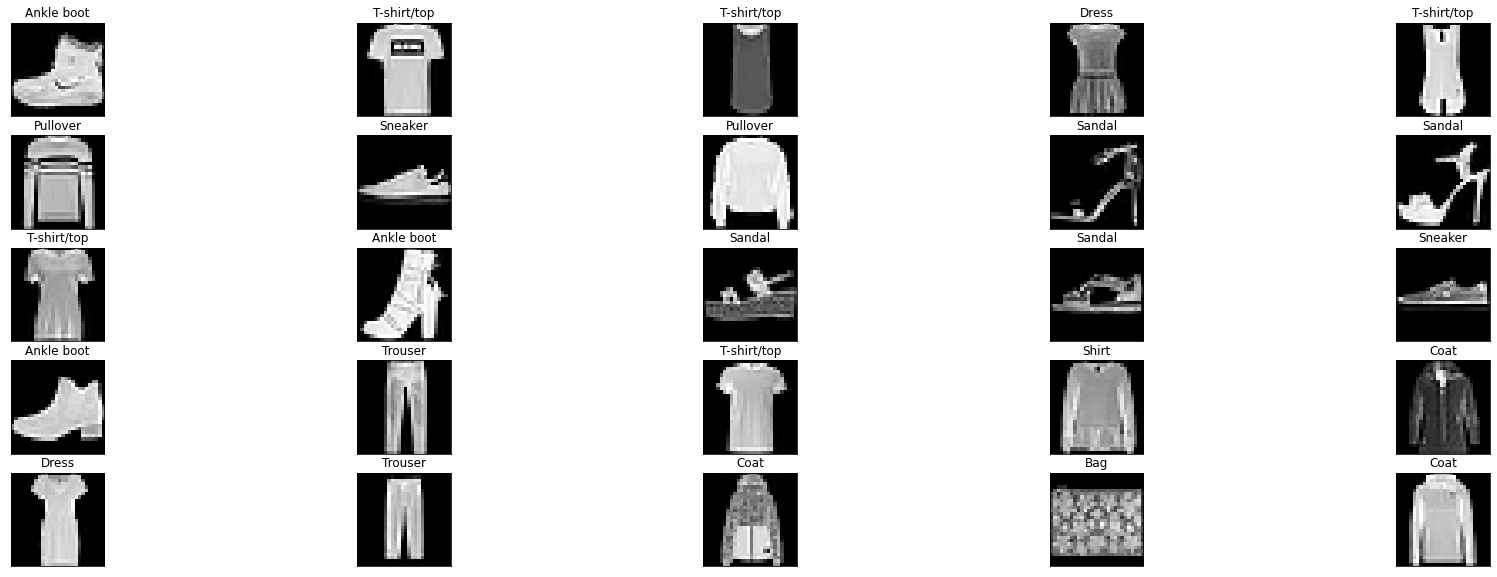

In [ ]:
fig = plt.figure(figsize=(30, 10))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    ax.set_title(f"{labels[y_train[i]]}")
    ax.imshow(x_train[i], cmap="gray")

The images are a bit small but they will do for now.

## A NN Model - First Attempt

Our first NN will be a simple one with a single hidden layer.

### Data Prep

**Tip**: NNs learn best when each independent variable is in a small range. So, standardize them by either 
- subtracting the mean and dividing by the standard deviation or 
- if they are in a guaranteed range, just divide by the max value.

The inputs here range from 0 to 255. Let's normalize to the 0-1 range by dividing everything by 255.

In [ ]:
x_train = x_train/ 255.0
x_test = x_test/ 255.0

### Define Model in Keras

As we saw in Lecture 2, creating an NN  is usually just a few lines of Keras code. 

* We will start with a single hidden layer. 
* The input will be 28 x 28 matrices of numbers. These will have to be *flattened* into a loooong vector and then fed to the hidden layer. **SWITCH TO PPT TO SHOW FLATTENING**.
* Since this is a *multi-class classification problem* (e.g., we need to predict one of 10 clothing categories), the output layer has to produce a 10-element vector of probabilities that sum up to 1.0  => we will use the *softmax* layer that we learned about in the previous lecture.

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden")(h)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)

# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what you have defined.

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Hidden (Dense)              (None, 256)               200960    
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


Let's hand-calculate the number of parameters to verify.

In [ ]:
(784 * 256 + 256) + (256 * 10 + 10) 

203530

Switch to PPT if you aren't quite clear about how we calculated the number of parameters.



---



---



We can "visualize" the network graphically as well using Keras' `plot_model` function.

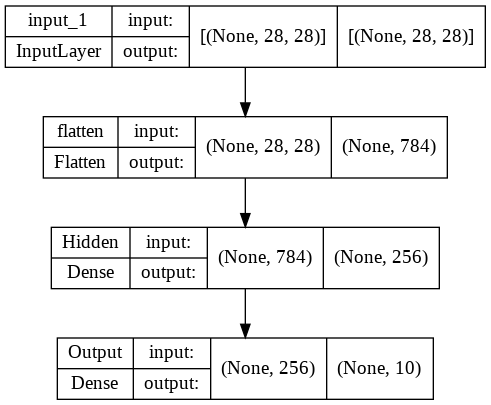

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

### Set Optimization Parameters

Now that the model is defined, we need to tell Keras three things:

*   What **loss function** to use 
*   Which **optimizer** to use - we will again use **Adam** which is an excellent set-and-forget choice 
*   What **metrics** you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.


Since our output variable is categorical with 10 levels, we will select the `sparse_categorical_crossentropy` loss function.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

### Train the Model!

* The *batch size*: 32 or 64 are commonly used
* The number of *epochs* i.e., how many passes through the training data: start with 10-20. 


---

OK, let's train the model using the `model.fit` function!


In [ ]:
batch_size = 64
epochs = 10

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
938/938 [==============================] - 6s 3ms/step - loss: 0.4995 - accuracy: 0.8254
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3741 - accuracy: 0.8651
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3353 - accuracy: 0.8773
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3069 - accuracy: 0.8888
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2903 - accuracy: 0.8923
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2755 - accuracy: 0.8974
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2621 - accuracy: 0.9015
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2484 - accuracy: 0.9081
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2403 - accuracy: 0.9103
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2326 - accuracy: 0.9135

### Evaluate the Model

You can see from the above that our model achieves over 91% accuracy on the train set but, as we know, doing well on the training set isn't all that impressive due to the possibility of overfitting. So the real question is **how well does it do on the test set?**

`model.evaluate` is a very handy function to calculate the performance of your model on any dataset.

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3221 - accuracy: 0.8890


[0.3221025764942169, 0.8889999985694885]

### What if we add a **second** hidden layer?

In [ ]:
# define the input layer
input = keras.Input(shape=(28,28))

# convert the 28 x 28 matrix of numbers into a long vector
h = keras.layers.Flatten()(input)

# feed the long vector to the first hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_1")(h)

# feed the output of the first hidden layer to the second hidden layer
h = keras.layers.Dense(256, activation="relu", name="Hidden_2")(h)

# feed the output of the second hidden layer to the output layer
output = keras.layers.Dense(10, activation="softmax", name="Output")(h)


# tell Keras that this (input,output) pair is your model
model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 Hidden_1 (Dense)            (None, 256)               200960    
                                                                 
 Hidden_2 (Dense)            (None, 256)               65792     
                                                                 
 Output (Dense)              (None, 10)                2570      
                                                                 
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


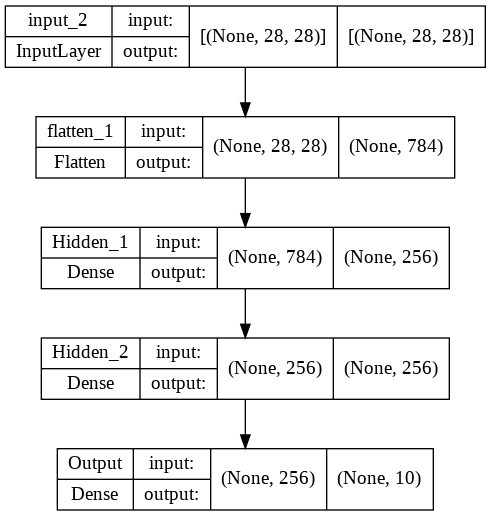

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
938/938 [==============================] - 4s 3ms/step - loss: 0.4786 - accuracy: 0.8292
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3547 - accuracy: 0.8698
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3231 - accuracy: 0.8812
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2973 - accuracy: 0.8902
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2828 - accuracy: 0.8935
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2664 - accuracy: 0.8995
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2549 - accuracy: 0.9042
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2405 - accuracy: 0.9095
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2319 - accuracy: 0.9117
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2227 - accuracy: 0.9146

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3164 - accuracy: 0.8886


[0.3164333403110504, 0.8885999917984009]

Accuracy hardly budged.

Adding a second hidden layer added 65,792 more parameters, so perhaps we have to run it for longer? Let's try another 10 epochs.

If we run `model.fit`, it will start with where we left off i.e. with the weights from the previous run.


In [ ]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2125 - accuracy: 0.9186
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2030 - accuracy: 0.9225
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1945 - accuracy: 0.9244
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1864 - accuracy: 0.9295
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1843 - accuracy: 0.9288
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1734 - accuracy: 0.9329
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1683 - accuracy: 0.9351
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1606 - accuracy: 0.9384
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1553 - accuracy: 0.9408
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1512 - accuracy: 0.9414

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3561 - accuracy: 0.8919


[0.3561413884162903, 0.8919000029563904]

Accuracy increased to over **89%**



> **TAKE-AWAY: The bigger the model, the longer we have to train it, to get good performance.**








> OpenAI's GPT-3 language model has 175 billion parameters and would require 355 years and $4,600,000 to train - even with the lowest priced GPU cloud on the market. [Source](https://lambdalabs.com/blog/demystifying-gpt-3/#:~:text=OpenAI%20recently%20published%20GPT%2D3,GPU%20cloud%20on%20the%20market.)



> **TAKE-AWAY: Classification model accuracy often shows a "diminishing marginal returns" behavior as the size of the network increases.**

## A Convolutional Neural Network




Did the NNs we create take advantage of the fact that the input data is **images**?

**SWITCH TO PPT**

<br>



### Convolutional Layers



Convolutional (typically abbreviated to "conv") layers were the key breakthrough that led to all the exciting advances in AI for Computer Vision problems like Image Classification, Image Recognition etc. They were designed to specifically work with images.

Conv layers are the reason why your iPhone can recognize your face! 

We will follow the same sequence of steps as we did above:


*   Data Prep
*   Define Model
*   Set Optimization Parameters
*   Train Model
*   Evaluate Model


### Data Prep

The data has already been normalized so that the numbers are between 0 and 1. We don't need to do it again.

In [ ]:
x_train.shape

(60000, 28, 28)

For reasons that will become clear later when we work with color images, we also need to add another dimension to each example so that it goes from 28x28 to 28x28x1

In [ ]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

### Define Model

OK, we are ready to create our very first **Convolutional Neural Network (CNN)!**



In [ ]:
input = keras.Input(shape=x_train.shape[1:])
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_1")(input) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Conv2D(32, kernel_size=(2, 2), activation="relu", name="Conv_2")(x) # convolutional layer!
x = keras.layers.MaxPool2D()(x) # pooling layer
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation="relu")(x)   
output = keras.layers.Dense(10, activation="softmax")(x)

model = keras.Model(input, output)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Conv_1 (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 Conv_2 (Conv2D)             (None, 12, 12, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1152)              0   

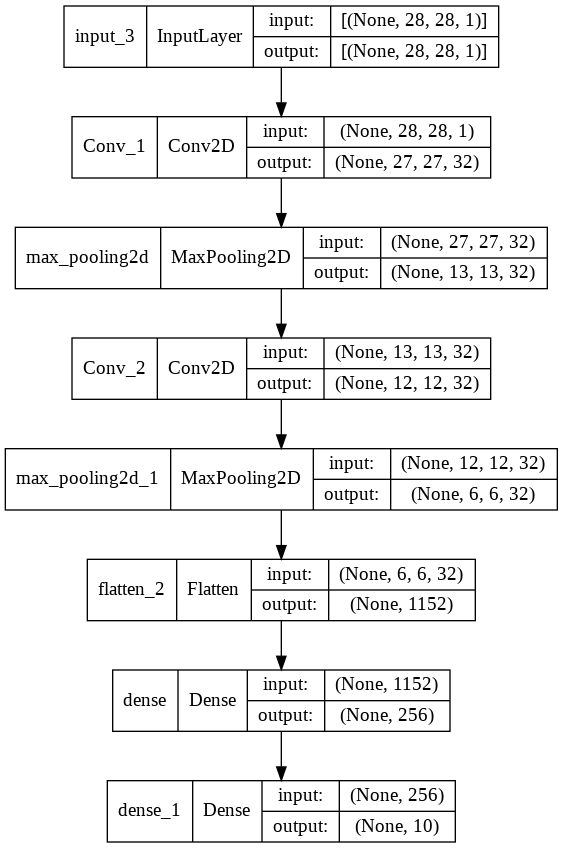

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Set Optimization Parameters

Same as before ....

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

### Train the Model

In [ ]:
model.fit(x_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
938/938 [==============================] - 13s 6ms/step - loss: 0.4824 - accuracy: 0.8263
Epoch 2/10
938/938 [==============================] - 6s 6ms/step - loss: 0.3239 - accuracy: 0.8820
Epoch 3/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2807 - accuracy: 0.8976
Epoch 4/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2492 - accuracy: 0.9081
Epoch 5/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2265 - accuracy: 0.9156
Epoch 6/10
938/938 [==============================] - 6s 6ms/step - loss: 0.2049 - accuracy: 0.9244
Epoch 7/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1875 - accuracy: 0.9300
Epoch 8/10
938/938 [==============================] - 6s 7ms/step - loss: 0.1682 - accuracy: 0.9377
Epoch 9/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1557 - accuracy: 0.9421
Epoch 10/10
938/938 [==============================] - 6s 6ms/step - loss: 0.1419 - accuracy: 0.946

### Evaluate the Model

In [ ]:
score = model.evaluate(x_test, y_test)
print("Test accuracy:", score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.2541 - accuracy: 0.9141
Test accuracy: 0.9140999913215637


**Excellent! We got to 91.4% accuracy on the test set!**




> **TAKEAWAY**: Using two **specialized layers - the convolutional and pooling layers -** helped us exceed 90%.



Back to Fashion MNIST. Let's see what the **[state of the art (SOTA)](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)** accuracy is.

It is **96.91%**!

<br>


**Challenge: Can you get to SOTA by playing around with the architecture of the network?**



## Iteratively Improving the Model 

> **Practical Tip**: Once any model is built, it is a good idea to look at the predictions on the test set and see what types of examples the model has difficulty predicting. That can often suggest ways in which the model can be improved.

For problems where the input data consists of *images* (like Fashion MNIST), **visualization** can be very helpful.


In [ ]:
# get the predictions
y_hat = np.argmax(model.predict(x_test), axis=1)

# collect examples where the model made a mistake
misses = np.where(y_hat != y_test)

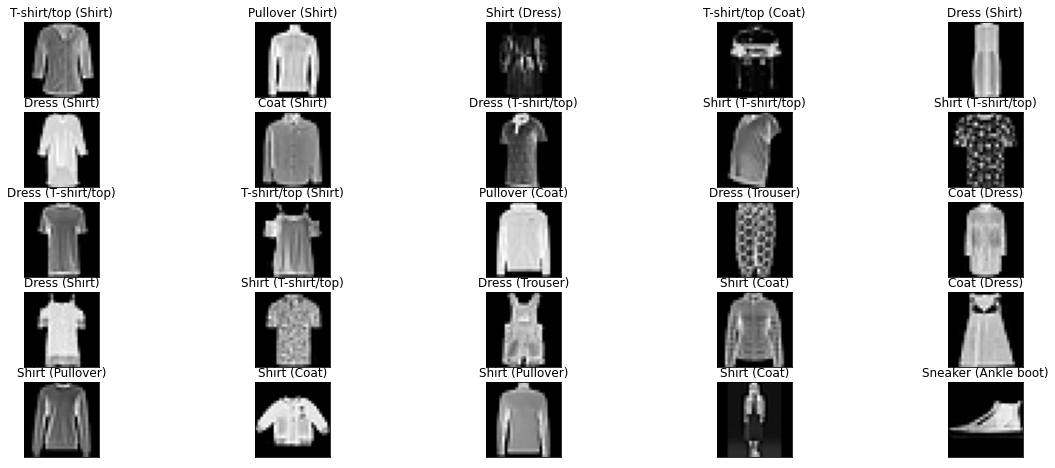

In [ ]:
# Plot a random sample of 25 test images incorrectly classified by the model, 
# their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(misses[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]), cmap="gray")
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[y_hat[index]], 
                                  labels[y_test[index]]))

You can see that the model seems to be having difficulty distinguishing between *visually similar* categories.

The **confusion matrix** is a good way to get a complete picture of this phenomenon.

In [ ]:
actuals = [labels[i] for i in y_test]
predictions = [labels[i] for i in y_hat]

In [ ]:
df = pd.DataFrame({'Predictions': predictions, 'Actuals': actuals})
pd.crosstab(df.Predictions, df.Actuals)

Actuals,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser
Predictions,,,,,,,,,,
Ankle boot,974,0,0,0,0,3,0,43,0,0
Bag,0,982,0,2,1,0,6,1,3,2
Coat,0,4,901,34,69,0,86,0,1,2
Dress,0,4,21,922,6,1,26,0,23,13
Pullover,0,2,36,5,862,0,57,0,9,1
Sandal,7,1,0,0,0,985,0,13,2,0
Shirt,1,1,40,20,39,0,696,0,63,3
Sneaker,18,1,0,0,0,11,0,943,0,0
T-shirt/top,0,5,2,14,23,0,129,0,899,2


**Observations**

*   All the off-diagonal numbers represent mistakes made by the model. 
*   You can see that the model made the most mistakes for "Shirts". It confused a "Shirt" for a "T-shirt/Top" often. This is understandable since the products are visually similar. 



---
**How can we improve the model?**

> **Tip**: Get more data on those categories that the model has difficulty distinguishing between (e.g., Shirts and T-Shirts), enrich the original training dataset with these new examples and re-train the model.




## Conclusion

We have built a Deep Learning model that can classify grayscale images of clothing items with over 90% accuracy!!


In the [next colab](https://colab.research.google.com/drive/18TNYD4_5a2PA3UTPOc4j2RNBFrofuk_T), we will discuss:
* How to work with color images
* A general strategy - **transfer learning** - for solving problems in practice
* Apply the general strategy to build a handbags/shoes classifier with just 100 examples!

**DONE**

